In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
# !pip3 install plotly
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import seaborn as sns

import string 
import re
import random

import nltk
#nltk.download()

from pywsd.utils import lemmatize_sentence
from nltk.stem import PorterStemmer 
from nltk.stem import LancasterStemmer
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from collections import Counter


from sklearn import preprocessing
from sklearn.model_selection import (cross_val_score, train_test_split)
from sklearn.grid_search import GridSearchCV

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from operator import itemgetter

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVR

import warnings
warnings.filterwarnings("ignore")


Warming up PyWSD (takes ~10 secs)... took 5.208317279815674 secs.
/Users/elenatong/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/Users/elenatong/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.

/Users/elenatong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



# 1. Understanding data

## 1.1 Read datasets

In [2]:
df = pd.read_csv("AppleStore.csv", index_col = 0)
display(df.head())
df.shape

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,1,Games,38,5,10,1
2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,1,Productivity,37,5,23,1
3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,1,Weather,37,5,3,1
4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,3,Shopping,37,5,9,1
5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,1,Reference,37,5,45,1


(7197, 16)

In [3]:
df.columns.values

array(['id', 'track_name', 'size_bytes', 'currency', 'price',
       'rating_count_tot', 'rating_count_ver', 'user_rating',
       'user_rating_ver', 'ver', 'cont_rating', 'prime_genre',
       'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic'],
      dtype=object)

In [4]:
df_description = pd.read_csv("appleStore_description.csv")
display(df_description.head())
df_description.shape

,id,track_name,size_bytes,app_desc
0,281656475,PAC-MAN Premium,100788224,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,281796108,Evernote - stay organized,158578688,Let Evernote change the way you organize your ...
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,Download the most popular free weather app pow...
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,The eBay app is the best way to find anything ...
4,282935706,Bible,92774400,On more than 250 million devices around the wo...


(7197, 4)

## 1.2 Merge datasets

In [5]:
df_merge = df.merge(df_description, on='id', how = 'outer')
df_merge = df_merge.drop(['track_name_y','size_bytes_y'], axis = 1)
df_merge = df_merge.rename(index=str, columns={"track_name_x": "track_name", "size_bytes_x": "size_bytes"})
display(df_merge.head())
df_merge.to_csv("df_merge.csv", sep='\t')

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,app_desc
0,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,1,Games,38,5,10,1,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,1,Productivity,37,5,23,1,Let Evernote change the way you organize your ...
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,1,Weather,37,5,3,1,Download the most popular free weather app pow...
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,3,Shopping,37,5,9,1,The eBay app is the best way to find anything ...
4,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,1,Reference,37,5,45,1,On more than 250 million devices around the wo...


In [6]:
df.isnull().sum()

id                  0
track_name          0
size_bytes          0
currency            0
price               0
rating_count_tot    0
rating_count_ver    0
user_rating         0
user_rating_ver     0
ver                 0
cont_rating         0
prime_genre         0
sup_devices.num     0
ipadSc_urls.num     0
lang.num            0
vpp_lic             0
dtype: int64

In [7]:
df_description.isnull().sum()

id            0
track_name    0
size_bytes    0
app_desc      0
dtype: int64

In [8]:
df_merge.isnull().sum()

id                  0
track_name          0
size_bytes          0
currency            0
price               0
rating_count_tot    0
rating_count_ver    0
user_rating         0
user_rating_ver     0
ver                 0
cont_rating         0
prime_genre         0
sup_devices.num     0
ipadSc_urls.num     0
lang.num            0
vpp_lic             0
app_desc            0
dtype: int64

## 1.3. Data Visulazition

### 1.3.1 Heatmap-correlation

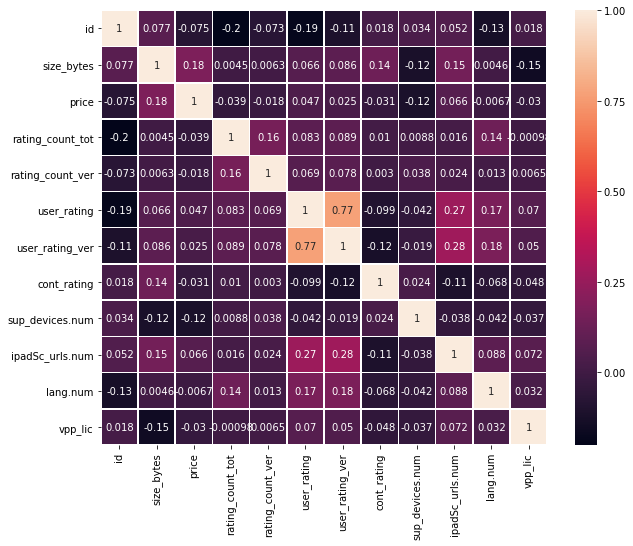

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(df_merge.corr(),annot=True,linewidths=0.5);
plt.show()

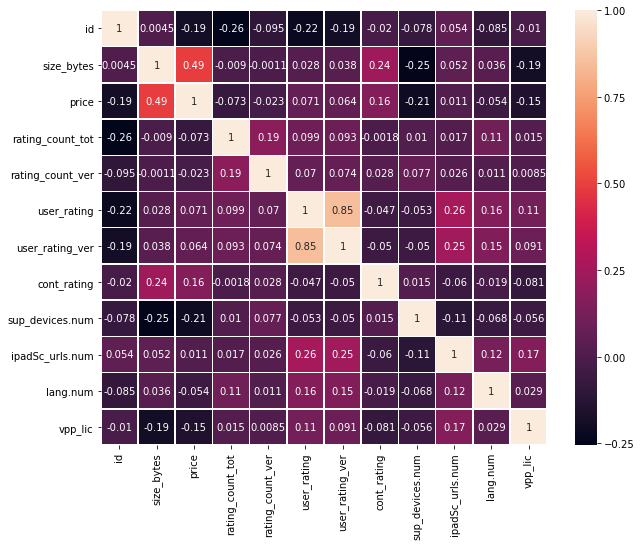

In [10]:
df_game = df_merge[df_merge['prime_genre'] == 'Games']
plt.figure(figsize=(10,8))
sns.heatmap(df_game.corr(),annot=True,linewidths=0.5);
plt.show()

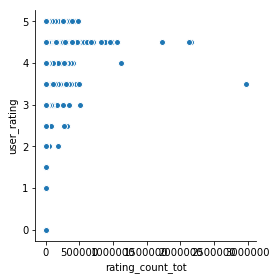

In [11]:
plt.figure(figsize=(10,5))
sns.pairplot(x_vars='rating_count_tot', y_vars='user_rating', data=df_merge, size=4.0);
plt.show()

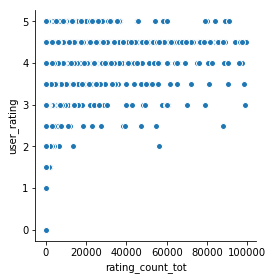

In [12]:
df_try = df_merge[df_merge['rating_count_tot']<100000]
#paidapps =df_merge[((df_merge.rating_count_tot<1000000) & (df_merge.rating_count_tot>0))]

plt.figure(figsize=(10,5))
sns.pairplot(x_vars='rating_count_tot', y_vars='user_rating', data=df_try, size=4.0);
plt.show()

### 1.3.2 APP count with category

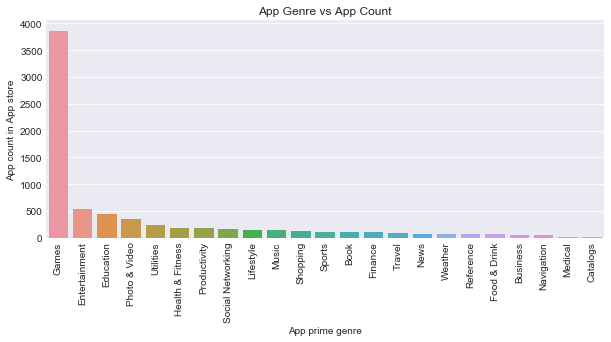

In [13]:
# count of apps for different app_genre categories in app store
app_count=df["prime_genre"].value_counts().reset_index()

# Plot of app counts for the various app_genre categories
plt.figure(figsize = (10, 4), facecolor = None)
sns.set_style("darkgrid")
plot1 = sns.barplot(x="index", y="prime_genre", data=app_count)

plot1.set_xticklabels(app_count['index'], rotation=90, ha="center")
plot1.set(xlabel='App prime genre',ylabel='App count in App store')
plot1.set_title('App Genre vs App Count')
plt.show()

*Games are the most numerous, followed by Entertainment, Education, Photo & Video.

In [14]:
#df_game = df[df['prime_genre'] == "Games"]
df_game = df_merge[df_merge['prime_genre'] == 'Games']
df_other = df_merge[df_merge['prime_genre'] != "Games" ]

print('There are {} Game Apps in this dataset'.format(df_game.shape[0]))
print('There are {} not Game Apps in this dataset'.format(df_other.shape[0]))

print("Games percentage:",len(df[df["prime_genre"] == "Games"])/len(df_merge))

There are 3862 Game Apps in this dataset
There are 3335 not Game Apps in this dataset
Games percentage: 0.5366124774211477


In [15]:
df.prime_genre.value_counts()

Games                3862
Entertainment         535
Education             453
Photo & Video         349
Utilities             248
Health & Fitness      180
Productivity          178
Social Networking     167
Lifestyle             144
Music                 138
Shopping              122
Sports                114
Book                  112
Finance               104
Travel                 81
News                   75
Weather                72
Reference              64
Food & Drink           63
Business               57
Navigation             46
Medical                23
Catalogs               10
Name: prime_genre, dtype: int64

In [16]:
def graph_tools(cnt_srs1, text1,cnt_srs2,text2):
    trace1 = go.Bar(
        x = cnt_srs1.index,
        y = cnt_srs1.values,
        text = text1,
        opacity = 0.7,
        name='Free'
    )

    trace2 = go.Bar(
        x = cnt_srs2.index,
        y = cnt_srs2.values,
        text = text2,
        opacity = 0.7,
        name='Not-Free'
    )
    fig = tools.make_subplots(rows=1, cols=1)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 1)
    fig['layout'].update(showlegend=False, width=800, height=400)
    fig['layout'].update(title='Grouped barplot containing Free(blue) and Not-Free(orange)')
    py.iplot(fig)

df_app_free = df_merge[((df_merge.price==0.00))]
df_app_notfree = df_merge[((df_merge.price!=0.00))]
    
srs1 = df_app_free['prime_genre'].value_counts()
text1 = ['{:.2f}%'.format(100 * (value / srs1.sum())) for value in srs1.values]

srs2 = df_app_notfree['prime_genre'].value_counts()
text2 = ['{:.2f}%'.format(100 * (value / srs2.sum())) for value in srs2.values]
graph_tools(srs1, text1,srs2,text2)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



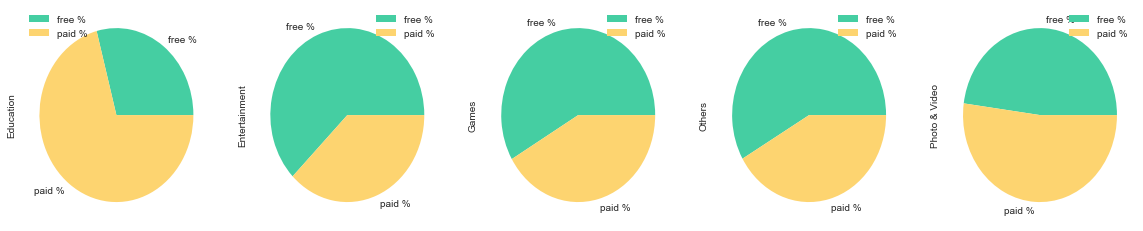

In [17]:
# reducing the number of categories
s = df_merge.prime_genre.value_counts().index[:4]
def categ(x):
    if x in s:
        return x
    else : 
        return "Others"

df_merge['broad_genre']= df_merge.prime_genre.apply(lambda x : categ(x))

free = df_merge[df_merge.price==0].broad_genre.value_counts().sort_index().to_frame()
paid = df_merge[df_merge.price>0].broad_genre.value_counts().sort_index().to_frame()
total = df_merge.broad_genre.value_counts().sort_index().to_frame()
free.columns=['free']
paid.columns=['paid']
total.columns=['total']
dist = free.join(paid).join(total)
dist ['paid_per'] = dist.paid*100/dist.total
dist ['free_per'] = dist.free*100/dist.total
dist

# for pie chart
pies = dist[['free_per','paid_per']]
pies.columns=['free %','paid %']
plt.show()

plt.figure(figsize=(15,8))
pies.T.plot.pie(subplots=True,figsize=(20,4),colors=['#45cea2','#fdd470'])
plt.show()

### 1.3.3.Price distribution

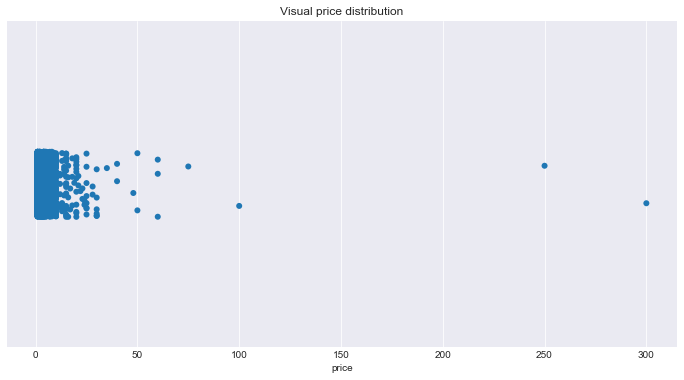

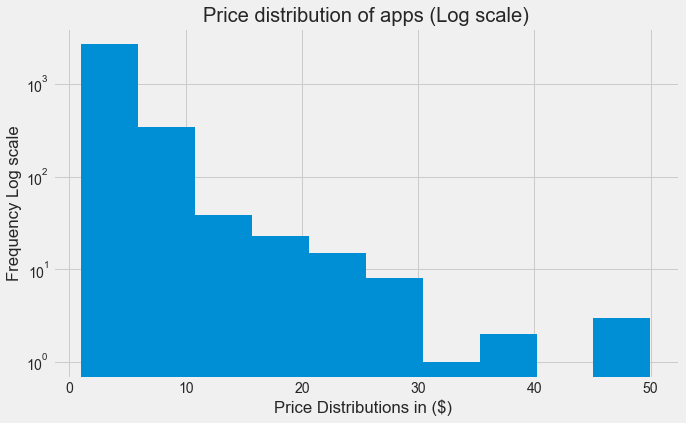

In [18]:
def price_distibution_frequency(df):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,6))
    #plt.subplot(2,1,1)

    plt.hist(df.price,log=True)
    plt.title('Price distribution of apps (Log scale)')
    plt.ylabel("Frequency Log scale")
    plt.xlabel("Price Distributions in ($) ")
    plt.show()
def price_distibution(df):
    #plt.subplot(2,1,2)
    #plt.style.use('fivethirtyeight')
    plt.figure(figsize=(12,6))
    plt.title('Visual price distribution')
    sns.stripplot(data=df,y='price',jitter= True,orient = 'h' ,size=6)
    plt.show()
paidapps_outliers =df_merge[((df_merge.price<1000000) & (df_merge.price>0))]
#price_distibution_frequency(paidapps_outliers)
price_distibution(paidapps_outliers)

paidapps =df_merge[((df_merge.price<50) & (df_merge.price>0))]
price_distibution_frequency(paidapps)
#price_distibution(paidapps)

In [19]:
df_merge[df_merge['price']>50]

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,app_desc,broad_genre
115,308368164,Proloquo2Go - Symbol-based AAC,723764224,USD,249.99,773,10,4.0,3.5,5.0.1,1,Education,37,5,3,1,Proloquo2Go is an award-winning symbol-support...,Education
162,320279293,NAVIGON Europe,144412672,USD,74.99,927,3,3.5,2.5,2.17,1,Navigation,37,2,21,1,"Whether on holiday, taking a weekend trip or h...",Others
1136,491998279,Articulation Station Pro,425919488,USD,59.99,294,130,4.5,5.0,2.2.3,1,Education,38,5,1,1,"""Little Bee Speech has created a real gem. Art...",Education
1479,551215116,LAMP Words For Life,583263232,USD,299.99,41,0,4.0,0.0,1.5.5,1,Education,24,5,1,1,LAMP Words For Life™ is a full English vocabul...,Education
2181,700440156,Articulation Test Center Pro,174737408,USD,59.99,29,0,4.5,0.0,2.6,1,Education,24,5,1,1,Created by certified Speech-Language Pathologi...,Education
2568,849732663,KNFB Reader,106429440,USD,99.99,71,0,4.5,0.0,2.7.3,1,Productivity,37,5,14,1,Take a pic. The app reads the print. \nThe app...,Others
3238,946930094,FineScanner Pro - PDF Document Scanner App + OCR,63974400,USD,59.99,100,4,4.0,4.5,6.2.5,1,Business,37,5,12,1,FineScanner turns your mobile device into a po...,Others


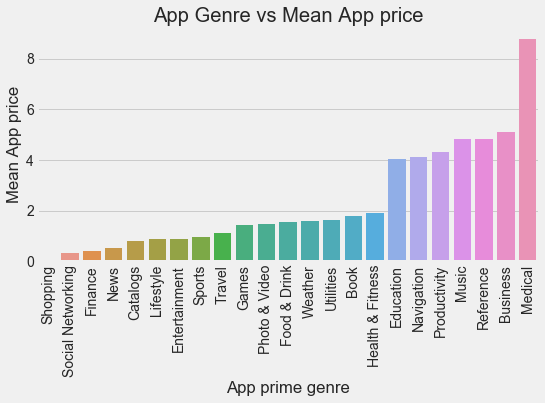

In [20]:
def mean_price_graph(df,n):
    # Getting the mean user ratings for the different App genre categories
    mean_user_ratings=df.groupby('prime_genre')['price'].mean().reset_index().sort_values(by=['price'])

    # plotting values for Average User rating vs App Genre
    plt.figure(figsize = (n, 4), facecolor = None)
    plot2 = sns.barplot(x="prime_genre", y="price", data=mean_user_ratings, order=mean_user_ratings['prime_genre'])

    plot2.set_xticklabels(mean_user_ratings['prime_genre'], rotation=90, ha="center")
    plot2.set(xlabel='App prime genre',ylabel='Mean App price')
    plot2.set_title('App Genre vs Mean App price')
    plt.show()
mean_price_graph(df_merge,8)

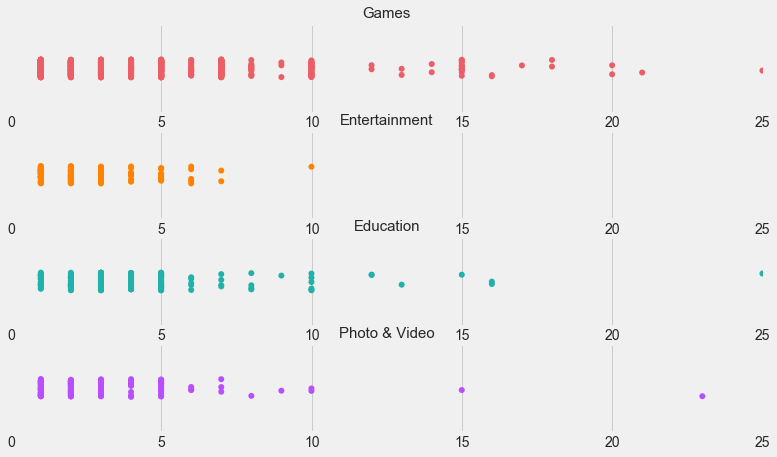

In [21]:
yrange = [0,25]
fsize =15
plt.figure(figsize=(12,7))
    
plt.subplot(4,1,1)
plt.xlim(yrange)
games = paidapps[paidapps.prime_genre=='Games']
sns.stripplot(data=games,y='price',jitter= True , orient ='h',size=6,color='#eb5e66')
plt.title('Games',fontsize=fsize)
plt.xlabel('') 

plt.subplot(4,1,2)
plt.xlim(yrange)
ent = paidapps[paidapps.prime_genre=='Entertainment']
sns.stripplot(data=ent,y='price',jitter= True ,orient ='h',size=6,color='#ff8300')
plt.title('Entertainment',fontsize=fsize)
plt.xlabel('') 

plt.subplot(4,1,3)
plt.xlim(yrange)
edu = paidapps[paidapps.prime_genre=='Education']
sns.stripplot(data=edu,y='price',jitter= True ,orient ='h' ,size=6,color='#20B2AA')
plt.title('Education',fontsize=fsize)
plt.xlabel('') 

plt.subplot(4,1,4)
plt.xlim(yrange)
pv = paidapps[paidapps.prime_genre=='Photo & Video']
sns.stripplot(data=pv,y='price',jitter= True  ,orient ='h',size=6,color='#b84efd')
plt.title('Photo & Video',fontsize=fsize)
plt.xlabel('') 

plt.show()

### 1.3.4 Avg user rating vs APP genre

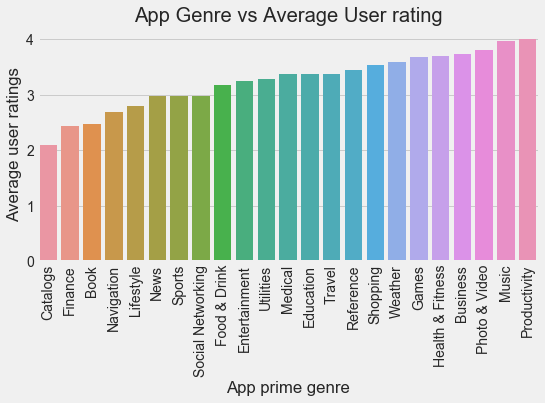

In [22]:
def avg_rating_graph(df,n):
    # Getting the mean user ratings for the different App genre categories
    mean_user_ratings=df.groupby('prime_genre')['user_rating'].mean().reset_index().sort_values(by=['user_rating'])

    # plotting values for Average User rating vs App Genre
    plt.figure(figsize = (n, 4), facecolor = None)
    plot2 = sns.barplot(x="prime_genre", y="user_rating", data=mean_user_ratings, order=mean_user_ratings['prime_genre'])

    plot2.set_xticklabels(mean_user_ratings['prime_genre'], rotation=90, ha="center")
    plot2.set(xlabel='App prime genre',ylabel='Average user ratings')
    plot2.set_title('App Genre vs Average User rating')
    plt.show()
avg_rating_graph(df_merge,8)

In [23]:
srs3 = df_app_free[['prime_genre', 'user_rating']].groupby('prime_genre').mean()['user_rating'].sort_values(ascending=False)
text3 = ['{:.2f}%'.format(100 * (value / srs3.sum())) for value in srs3.values]

srs4 = paidapps[['prime_genre', 'user_rating']].groupby('prime_genre').mean()['user_rating'].sort_values(ascending=False)
text4 = ['{:.2f}%'.format(100 * (value / srs4.sum())) for value in srs4.values]

graph_tools(srs3, text3,srs4,text4)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



### 1.3.5 user_rating count

*The Apps for Productivity, Music and Photo & Vidio have higher mean user rating.

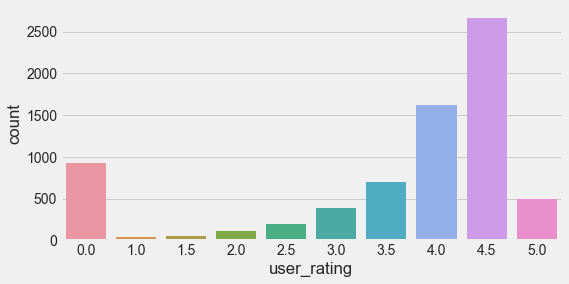

In [24]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(8)
sns.countplot(df_merge["user_rating"])
plt.show()

In [25]:
df_above = df_merge[df_merge['user_rating'] >= 4.5]
df_below = df_merge[df_merge['user_rating'] <4.5 ]

print('There are {} Apps rating above 4.5'.format(df_above.shape[0]))
print('There are {} Apps rating below 4.5'.format(df_below.shape[0]))

print("above percentage:",len(df_above)/(len(df_merge)))

There are 3155 Apps rating above 4.5
There are 4042 Apps rating below 4.5
above percentage: 0.4383771015700986


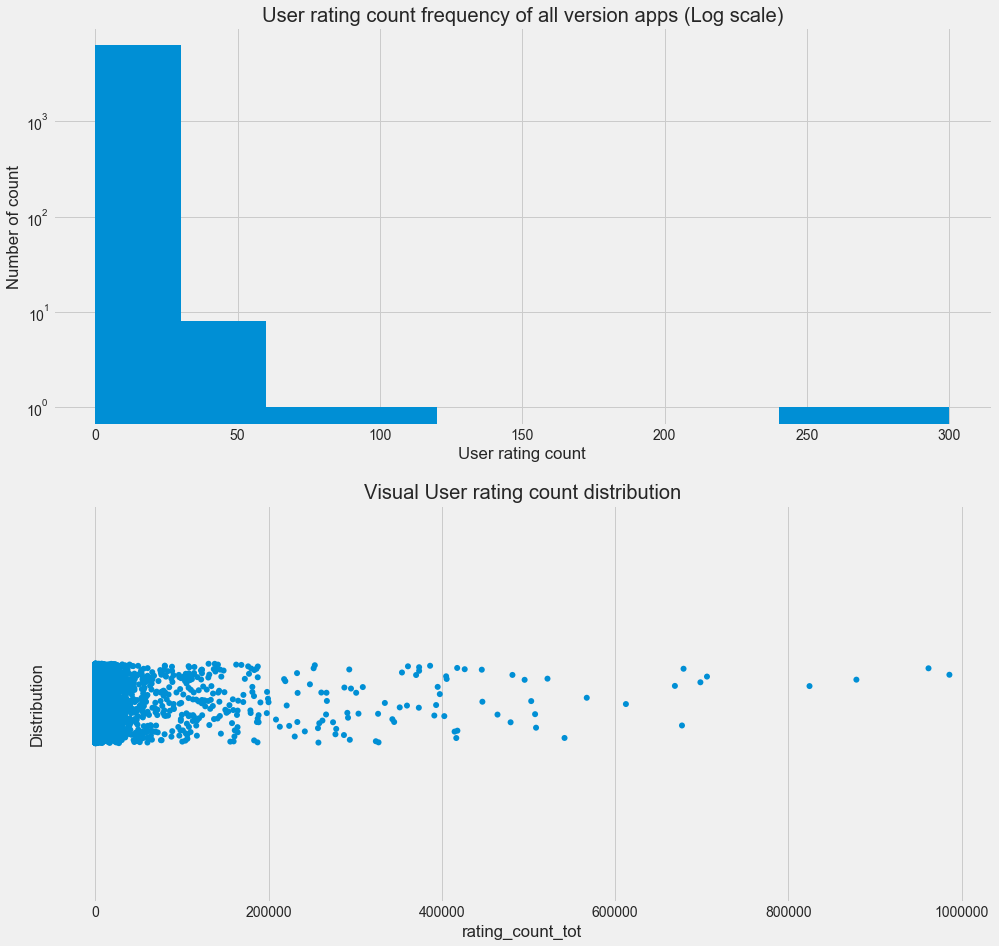

In [26]:
paidapps =df_merge[((df_merge.rating_count_tot<1000000) & (df_merge.rating_count_tot>0))]
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)

plt.hist(paidapps.price,log=True)
plt.title('User rating count frequency of all version apps (Log scale)')
plt.ylabel("Number of count")
plt.xlabel("User rating count")

plt.subplot(2,1,2)
plt.title('Visual User rating count distribution')
plt.ylabel("Distribution")
sns.stripplot(data=paidapps,y='rating_count_tot',jitter= True,orient = 'h' ,size=6)
plt.show()


In [27]:
print(len(df_merge[df_merge['rating_count_tot'] == 0]))

929


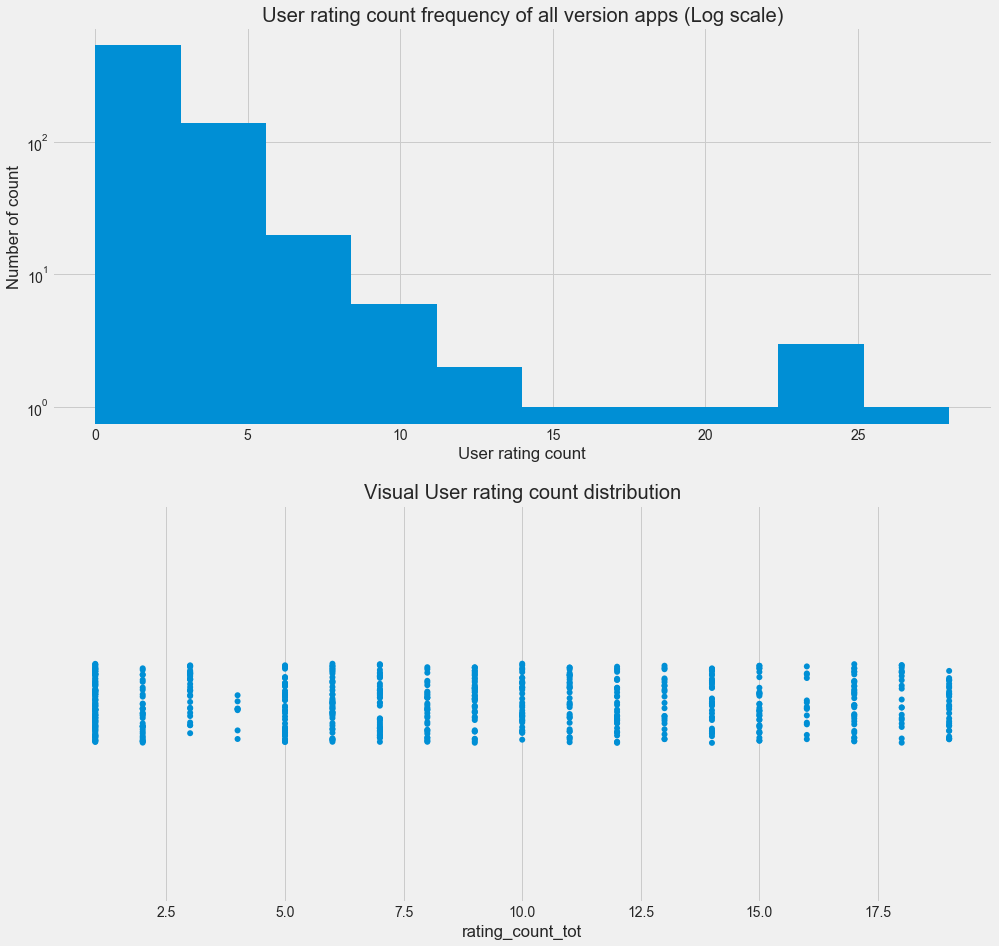

In [28]:
paidapps20 =df_merge[((df_merge.rating_count_tot<20) & (df_merge.rating_count_tot>0))]
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)

plt.hist(paidapps20.price,log=True)
plt.title('User rating count frequency of all version apps (Log scale)')
plt.ylabel("Number of count")
plt.xlabel("User rating count")

plt.subplot(2,1,2)
plt.title('Visual User rating count distribution')
sns.stripplot(data=paidapps20,y='rating_count_tot',jitter= True,orient = 'h' ,size=6)
plt.show()

In [29]:
srs5 = df_app_free[['prime_genre', 'size_bytes']].groupby('prime_genre').mean()['size_bytes'].sort_values(ascending=False)
text5 = ['{:.2f}%'.format(100 * (value / srs5.sum())) for value in srs5.values]
srs6 = df_app_notfree[['prime_genre', 'size_bytes']].groupby('prime_genre').mean()['size_bytes'].sort_values(ascending=False)
text6 = ['{:.2f}%'.format(100 * (value / srs6.sum())) for value in srs6.values]
graph_tools(srs5, text5, srs6, text6)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



# 2. Text mining

In [30]:
searchfor = ['save', 'discount']
df_search = df_merge[df_merge.app_desc.str.contains('|'.join(searchfor))]
display(df_search.head())

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,app_desc,broad_genre
1,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,1,Productivity,37,5,23,1,Let Evernote change the way you organize your ...,Others
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,3,Shopping,37,5,9,1,The eBay app is the best way to find anything ...,Others
10,284791396,Solitaire by MobilityWare,49618944,USD,4.99,76720,4017,4.5,4.5,4.10.1,1,Games,38,4,11,1,Solitaire by MobilityWare is the ORIGINAL make...,Games
14,284862767,FreeCell,55153664,USD,4.99,6340,668,4.5,4.5,4.0.3,1,Games,38,5,2,1,Play the BEST FreeCell Solitaire game on your ...,Games
15,284876795,TripAdvisor Hotels Flights Restaurants,207907840,USD,0.00,56194,87,4.0,3.5,21.1,1,Travel,37,1,26,1,"Millions of traveler reviews, photos, and maps...",Others


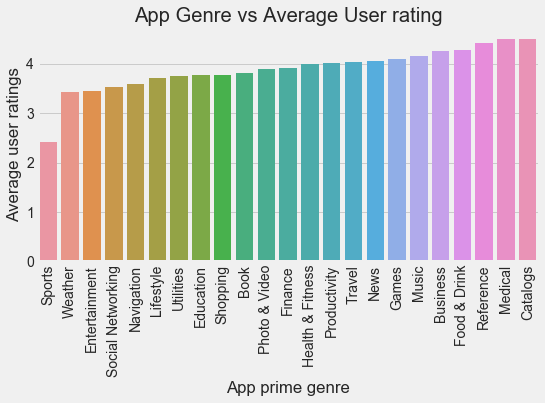

In [31]:
avg_rating_graph(df_search,8)

## 2.1 High Frequency words

### 2.1.1 split data

In [32]:
#display(df_game.head())
train_game = df_game.sample(frac=0.70, random_state=99)
test_game = df_game.loc[~df_game.index.isin(train_game.index), :]

### 2.1.2 count number of words

In [33]:
#display(df_game.head())
def wordsplit(df):
    wordlist = df.app_desc.str.split(expand=True).stack().value_counts()
    #print(wordlist.head())
    print("Total number of words:", sum(wordlist.values))
    return wordlist
display(wordsplit(train_game).head())

Total number of words: 601298


the     22617
and     20632
to      15552
of      11422
your     9857
dtype: int64

### 2.1.3 Non-English reviews

In [34]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


def English_review(df):
    boo = []
    i = 0
    for x in df.track_name:
        boo.append(isEnglish(x))
        boo[i] = isEnglish(x)
        i+= 1
    df['English'] = boo
    return df



### 2.1.4 Good and Bad game count 

In [35]:
def GandB_count(df, c, n):
    goodgame = df[df[c] >= n]
    badgame = df[df[c] < n]

    # only english  
    game_engl_good = English_review(goodgame)
    game_engl_bad = English_review(badgame)

    Englishgoodgame = goodgame[goodgame['English'] == True]
    Englishbadgame = badgame[badgame['English'] == True]
    
    print("total num game :" + str(len(df_game)))
    print("total num game in training dataset:" + str(len(df)))
    print("total num goodgame :" + str(len(goodgame)))
    print("total num goodEnglishgame :" + str(len(Englishgoodgame)))
    print("total num badgame :" + str(len(badgame)))
    print("total num badEnglishgame :" + str(len(Englishbadgame)))
    return Englishgoodgame, Englishbadgame

In [36]:
df_Englishgoodgame, df_Englishbadgame = GandB_count(train_game, 'user_rating' ,4.5)

total num game :3862
total num game in training dataset:2703
total num goodgame :1379
total num goodEnglishgame :1248
total num badgame :1324
total num badEnglishgame :969


### 2.1.4 remove stopwords and stemming

In [37]:
def RemoveStopword_SimplifyTense(s):
    num =[]
    nostopword_des = []
    i = 0
    exclude = set(string.punctuation)

    for x in s.app_desc:
        x = re.sub(r'[^\w\s]','',x)
    #print(x.split())
        lemmatize_sentence(x)
        filtered_sentence = []
        for r in x.split():
            if not r.lower() in stopwords.words('english'):
                r = wordnet_lemmatizer.lemmatize(r, pos = "v")
                r = wordnet_lemmatizer.lemmatize(r, pos = "n")
                filtered_sentence.append(r.lower())
            
    #print (filtered_sentence)
        num.append(len(filtered_sentence))
        nostopword_des.append(filtered_sentence)
    
        num[i] = len(filtered_sentence)
        nostopword_des[i] = filtered_sentence
        i+= 1
    
    s['word_num'] = num
    s['nostopword_des'] = nostopword_des
    
    #display(df.head(10))
    return s

In [38]:
wordnet_lemmatizer = WordNetLemmatizer()

df_egg = RemoveStopword_SimplifyTense(df_Englishgoodgame)
print ("Destription words mean is %f\r\n" %(np.mean(df_egg.word_num)))
print ("Destription words median is %f\r\n" %(np.median(df_egg.word_num)))
df_ebg = RemoveStopword_SimplifyTense(df_Englishbadgame)
print ("Destription words mean is %f\r\n" %(np.mean(df_ebg.word_num)))
print ("Destription words median is %f\r\n" %(np.median(df_ebg.word_num)))

#display(df_egg.head())

Destription words mean is 157.032853

Destription words median is 147.000000

Destription words mean is 140.726522

Destription words median is 129.000000



In [39]:
goodwordlists = pd.Series(np.concatenate([x for x in df_egg.nostopword_des])).value_counts()
goodwordList = pd.DataFrame({'goodwordlists':goodwordlists.index, 'goodfrequence':goodwordlists.values})
#goodwordList["index"] = goodwordList.index

badwordlists = pd.Series(np.concatenate([x for x in df_ebg.nostopword_des])).value_counts()
badwordList = pd.DataFrame({'badwordlists':badwordlists.index, 'badfrequence':badwordlists.values})
#badwordList["index"] = badwordList.index
display(goodwordList.head())
display(badwordList.head())

,goodwordlists,goodfrequence
0,game,4152
1,play,1938
2,new,1538
3,world,1061
4,use,903


,badwordlists,badfrequence
0,game,3017
1,play,1290
2,new,972
3,world,721
4,use,693


### 2.1.5 Part-of-Speech tagging

In [40]:
def Synsets(s,j):
    syn = []
    i = 0
    for w in s.index:

        if wn.synsets(w):
            syn.append(wn.synsets(w)[0].pos())
            syn[i] = wn.synsets(w)[0].pos()
            i+=1
        else:
            syn.append("null")
            syn[i] = "null"
            i+=1
    j['Synsets'] = syn
Synsets(goodwordlists,goodwordList)
Synsets(badwordlists,badwordList)

goodwordList.to_csv("Goodwordlist.csv", sep='\t')
badwordList.to_csv("Badwordlists.csv", sep='\t')

In [41]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

In [42]:
def checkNums(s,j):
    num = []
    i = 0
    for w in s.index:
        num.append(hasNumbers(w))
        num[i] = hasNumbers(w)
        i+=1
        
    j['NumCheck'] = num
    j[j['NumCheck'] == False] 

checkNums(goodwordlists,goodwordList)
checkNums(badwordlists,badwordList)

In [43]:
#display(goodwordList.head())
#display(badwordList.head())


goodwordList = goodwordList[goodwordList['NumCheck'] == False]
badwordList = badwordList[badwordList['NumCheck'] == False]
topGoodwordList = goodwordList.head(1000)
topBadwordList = badwordList.head(1000)
#display(badwordList.head())
topGoodwordList.drop(['Synsets'], axis = 1)
topBadwordList.drop(['NumCheck'], axis = 1)
topGoodwordList.shape
#topGoodwordList.to_csv("test.csv", sep='\t')

(1000, 4)

In [44]:
allwords = topGoodwordList.merge(topBadwordList, left_on='goodwordlists', right_on='badwordlists', how='outer')
#display(allwords.head(10))
allwords["goodfrequence"]=allwords["goodfrequence"]/1.2
allwords["Difference"] = allwords["goodfrequence"]-allwords["badfrequence"]
#display(allwords.head(10))

In [45]:
allwords_diff = allwords.sort_values(by=['Difference'],ascending=False)
display(allwords_diff.head(10))

,goodwordlists,goodfrequence,Synsets_x,NumCheck_x,badwordlists,badfrequence,Synsets_y,NumCheck_y,Difference
0,game,3460.000000,n,False,game,3017.0,n,False,443.000000
1,play,1615.000000,n,False,play,1290.0,n,False,325.000000
2,new,1281.666667,a,False,new,972.0,a,False,309.666667
6,level,728.333333,n,False,level,463.0,n,False,265.333333
7,free,613.333333,n,False,free,427.0,n,False,186.333333
25,unique,450.833333,s,False,unique,276.0,s,False,174.833333
13,puzzle,570.833333,n,False,puzzle,397.0,n,False,173.833333
28,build,427.500000,n,False,build,256.0,n,False,171.500000
24,battle,453.333333,n,False,battle,287.0,n,False,166.333333
31,collect,403.333333,n,False,collect,240.0,n,False,163.333333


In [46]:
for i in allwords["Difference"]:
    if i =='Na':
        print(i)

In [47]:
allwords["Ratio"] = (allwords["goodfrequence"]/allwords["badfrequence"])*100
allwords_ratio = allwords.sort_values(by=['Ratio'],ascending=False)
allwords_ratio.to_csv("DIFF.csv", sep='\t')
display(allwords_ratio.head(10))

,goodwordlists,goodfrequence,Synsets_x,NumCheck_x,badwordlists,badfrequence,Synsets_y,NumCheck_y,Difference,Ratio
245,dragon,116.666667,n,False,dragon,34.0,n,False,82.666667,343.137255
307,treasure,93.333333,n,False,treasure,28.0,n,False,65.333333,333.333333
207,cat,129.166667,n,False,cat,40.0,n,False,89.166667,322.916667
364,subscription,81.666667,n,False,subscription,29.0,n,False,52.666667,281.609195
240,candy,118.333333,n,False,candy,44.0,n,False,74.333333,268.939394
333,dungeon,86.666667,n,False,dungeon,33.0,n,False,53.666667,262.626263
439,rush,70.000000,n,False,rush,28.0,n,False,42.000000,250.000000
133,reward,175.000000,n,False,reward,71.0,n,False,104.000000,246.478873
358,bubble,83.333333,n,False,bubble,35.0,n,False,48.333333,238.095238
162,word,156.666667,n,False,word,66.0,n,False,90.666667,237.373737


In [48]:
da = pd.read_csv("Dmanual.csv", index_col = 0)

str1 = ' '.join(da.goodwordlists)
str1 = str1.split()
print(str1)

['dragon', 'treasure', 'cat', 'subscription', 'candy', 'dungeon', 'rush', 'reward', 'bubble', 'word', 'prize', 'ninja', 'winner', 'kingdom', 'form', 'combo', 'piece', 'million', 'community']


### 2.2 Test

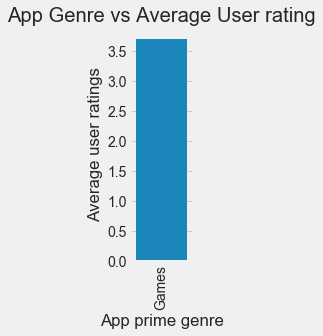

In [49]:
avg_rating_graph(train_game,1)

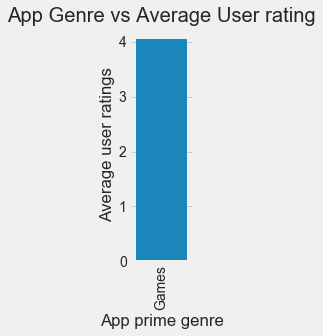

In [50]:
searchlist = ['dragon', 'treasure', 'cat', 'subscription', 'candy', 'dungeon', 'rush', 'reward', 'bubble', 'word', 'prize', 'ninja', 'winner', 'kingdom', 'form', 'combo', 'piece', 'million', 'community']
df_searchlist = test_game[test_game.app_desc.str.contains('|'.join(searchlist))]
#display(df_search.head())

avg_rating_graph(df_searchlist,1)

In [51]:
    sy = []
    a = 0
    b = 0
    for i in df_game.app_desc:
        
        if any (word in i for word in str1):
          
           
            sy.append(1)
            sy[a] = 1
            a+= 1
            
        else:
        
            sy.append(0)
            sy[a] = 0
            b+= 1
    df_game["highFre_Check"] = sy
     
    display(df_game.head())
    #df_game['Filte'] = sy
   

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,app_desc,highFre_Check
0,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,1,Games,38,5,10,1,"SAVE 20%, now only $3.99 for a limited time!\n...",1
5,283619399,Shanghai Mahjong,10485713,USD,0.99,8253,5516,4.0,4.0,1.8,1,Games,47,5,1,1,"★ WINNER ""BEST GAME"" 2009\n★ 3rd PLACE WINNER ...",1
9,284736660,Ms. PAC-MAN,70023168,USD,3.99,7885,40,4.0,4.0,4.0.4,1,Games,38,0,10,1,Now with MFi controller support!\n\nMs. PAC-MA...,1
10,284791396,Solitaire by MobilityWare,49618944,USD,4.99,76720,4017,4.5,4.5,4.10.1,1,Games,38,4,11,1,Solitaire by MobilityWare is the ORIGINAL make...,1
11,284815117,SCRABBLE Premium,227547136,USD,7.99,105776,166,3.5,2.5,5.19.0,1,Games,37,0,6,1,CONNECT WITH FRIENDS. PLAY WITH WORDS. Get a g...,1


In [52]:
print(len(df_game[df_game['highFre_Check'] == 0]))

924


In [53]:
print(len(df_game[df_game['highFre_Check'] == 1]))

2938


# 3. Prediction

## 3.1 preprocessing

### 3.1.1 Delete rating 0

In [54]:
df_merge = df_merge[df_merge['user_rating'] != 0]
#display(df_merge.head())

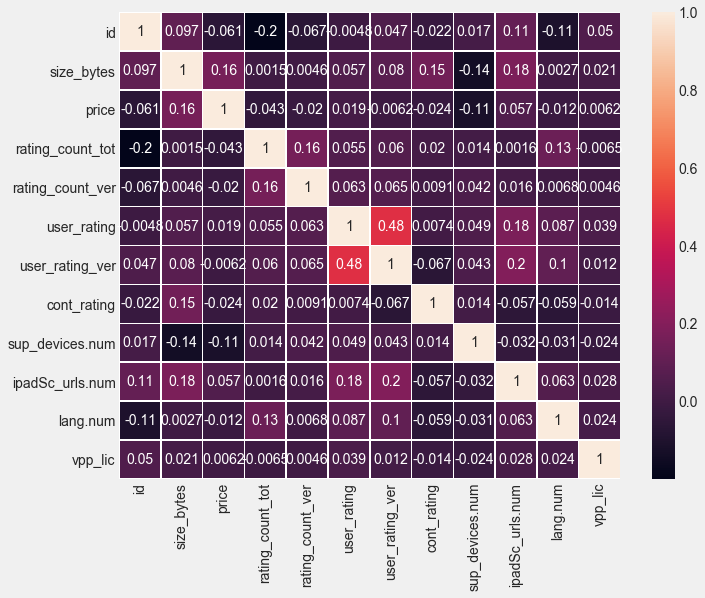

In [55]:
plt.figure(figsize=(10,8))
sns.heatmap(df_merge.corr(),annot=True,linewidths=0.5);
plt.show()

In [56]:
df_above = df_merge[df_merge['user_rating'] >= 4.5]
df_below = df_merge[df_merge['user_rating'] <4.5 ]

print('There are {} Apps rating above 4.5'.format(df_above.shape[0]))
print('There are {} Apps rating below 4.5'.format(df_below.shape[0]))

print("above percentage:",len(df_above)/(len(df_merge)))

There are 3155 Apps rating above 4.5
There are 3113 Apps rating below 4.5
above percentage: 0.5033503509891513


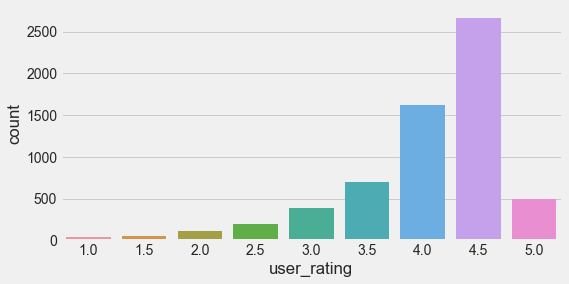

In [57]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(8)
sns.countplot(df_merge["user_rating"])
plt.show()

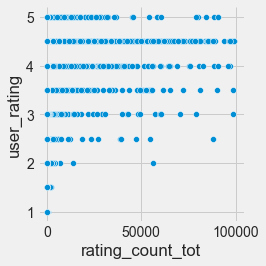

In [58]:
df_try_d = df_merge[df_merge['rating_count_tot']<100000]
#paidapps =df_merge[((df_merge.rating_count_tot<1000000) & (df_merge.rating_count_tot>0))]

plt.figure(figsize=(10,5))
sns.pairplot(x_vars='rating_count_tot', y_vars='user_rating', data=df_try_d, size=4.0);
plt.show()

### 3.1.2 Preprocessing

In [59]:
cols_drop = ['id','track_name','currency','ver', 'prime_genre', 'app_desc','broad_genre']
dt = df_merge.drop(cols_drop, axis = 1)

In [60]:
data_scaled = preprocessing.scale(dt)
data_scaled = pd.DataFrame( data= data_scaled, columns = dt.columns.values)

# Utility Functions

In [61]:
def model_selection(clf, param_grid, X , y):
    cv = KFold(n_splits=3, shuffle=True, random_state=13)
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=cv)
    grid_search.fit(X, y)
    return grid_search

def report(grid_scores, n_top):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.4f}, Standard Deviation: {1:.4f}".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

def report_model_score(clf, X, y, cv=3):
    scores = cross_val_score(clf, X, y, cv=3, n_jobs=-1)
    print('Model Report: ')
    print('Mean cv score: {:.3f} +/- std: {:.3f}'.format(np.mean(scores), np.std(scores)))

def report_model_score_regressor(regr, X, y, cv=3):
    scores = cross_val_score(regr, X, y, cv=3, n_jobs=-1)
    print('Model Report: ')
    print('Mean R^2 score: {:.3f} +/- std: {:.3f}'.format(np.mean(scores), np.std(scores)))
    
def plot_confusion_matrix(confusion_matrix):
    heatmap = sns.heatmap(confusion_matrix, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.show()

## 3.2 Regression

In [62]:
#Linear regression
def linear_function(X_train, X_test, y_train, y_test):
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    
    mse = mean_squared_error(y_test,y_pred)
    R = regr.score(X_test, y_test) 
    AdjustedR = 1 - (1-regr.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    return mse, R, AdjustedR

In [137]:
#Random forest
def rf_function(X_train, X_test, y_train, y_test):
    #rf = RandomForestRegressor(n_estimators=60, min_samples_split=200, min_samples_leaf=3,
                               #max_depth=8, max_features=8, random_state=13)
    rf = RandomForestRegressor(random_state = 13)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    R = rf.score(X_test, y_test) 
    AdjustedR = 1 - (1- rf.score(X_test, y_test)) *(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    return mse, R, AdjustedR

In [138]:
def svr_function(X_train, X_test, y_train, y_test):
    sv = SVR()
    sv.fit(X_train, y_train)
    y_pred = sv.predict(X_test)
    
    mse = mean_squared_error(y_test,y_pred)
    R = sv.score(X_test, y_test) 
    AdjustedR = 1 - (1- sv.score(X_test, y_test)) *(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    return mse, R, AdjustedR

In [139]:
def split_data(X_train, X_test, y_train, y_test, method): 
    summary = pd.DataFrame(data=[], columns=["MSE", "R", "AdjustedR"])
    
    if method =='Linear Rgression':
        mse, R, AdjustedR = linear_function(X_train, X_test, y_train, y_test)
    elif method == 'Random Forest Regression':
        mse, R, AdjustedR = rf_function(X_train, X_test, y_train, y_test)
    elif method == 'SVR':
        mse, R, AdjustedR = svr_function(X_train, X_test, y_train, y_test)
                
    measures = []
    measures = np.append(measures, mse)
    measures = np.append(measures, R)
    measures = np.append(measures, AdjustedR)
    result_ser = pd.Series(measures, index= ["MSE", "R", "AdjustedR"])
    summary = summary.append(result_ser,ignore_index=True)
    return summary, np.mean(summary, axis = 0)

In [140]:
def regression_result(X_train, X_test, y_train, y_test):
    summary = pd.DataFrame(data=[], columns=["Method", "MSE", "R", "AdjustedR"])
    methods = [ "Linear Rgression", "Random Forest Regression", "SVR"]

    for method in methods:
        summ, avg = split_data(X_train, X_test, y_train, y_test, method)
        summary = summary.append(pd.Series(avg, index=["Method", "MSE", "R", "AdjustedR"]), ignore_index=True)
    summary.Method = [ "Linear Rgression", "Random_Forest_Regression", "SVR"]
    
    return summary

### 3.2.1 Test 1 - Predicting User Rating

In [67]:
#(1.a)	The model can only be used for user-rating data loss 
#(x include user_rating_ver, rating_count_tot, and rating_count_ver.)
X1a = dt.drop(['user_rating'], axis=1)
X_scaled1a = preprocessing.scale(X1a)
y1a = dt['user_rating']
X_train1a, X_test1a, y_train1a, y_test1a = train_test_split(X_scaled1a, y1a, test_size=0.33, random_state=13)
regression_result(X_train1a, X_test1a, y_train1a, y_test1a)

,Method,MSE,R,AdjustedR
0,Linear Rgression,0.396726,0.232321,0.228591
1,Random_Forest_Regression,0.257208,0.502294,0.499876
2,SVR,0.283297,0.451810,0.449146


In [68]:
#(1.b)	use the rating for current version and current rating count to predict the rating of all versions 
#(x contains user_rating_ver, rating_count_ver and delete rating_count_tot.)

X1b = dt.drop(['user_rating', 'rating_count_tot'], axis=1)
X_scaled1b = preprocessing.scale(X1b)
y1b = dt['user_rating']
X_train1b, X_test1b, y_train1b, y_test1b = train_test_split(X_scaled1b, y1b, test_size=0.33, random_state=13)
regression_result(X_train1b, X_test1b, y_train1b, y_test1b)

,Method,MSE,R,AdjustedR
0,Linear Rgression,0.396977,0.231837,0.228479
1,Random_Forest_Regression,0.277069,0.463863,0.461519
2,SVR,0.287160,0.444337,0.441908


### Baseline Model

In [69]:
rfr_baseline = RandomForestRegressor(random_state = 13)

In [70]:
rfr_baseline.fit(X_train1b, y_train1b)
rfr_baseline.score(X_test1b, y_test1b)

0.3790215758590496

In [71]:
report_model_score_regressor(rfr_baseline, X_train1b, y_train1b)

Model Report: 
Mean R^2 score: 0.419 +/- std: 0.020


### Visualize Confusion Matrix

In [72]:
_ = rfr_baseline.fit(X_train1b, y_train1b)

In [73]:
y_pred_rfr = rfr_baseline.predict(X_test1b)

### Test Accuracy

In [74]:
print('The R^2 score for baseline model (rf) is {:.3f}'.
      format(rfr_baseline.score(X_test1b, y_test1b)))

The R^2 score for baseline model (rf) is 0.379


## Hyper-parameters Tuning

### Step 1: Finding the best initial number of estimators

In [75]:
rfr = RandomForestRegressor(random_state=13)
param_test1_rfr = {"n_estimators": np.arange(20, 121, 20)}

In [76]:
grid_search = GridSearchCV(rfr, param_grid=param_test1_rfr, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train1b, y_train1b)

In [77]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.4517, Standard Deviation: 0.0140
Parameters: {'n_estimators': 60}

Model with rank: 2
Mean validation score: 0.4515, Standard Deviation: 0.0149
Parameters: {'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.4514, Standard Deviation: 0.0165
Parameters: {'n_estimators': 120}



In [78]:
rfr = RandomForestRegressor(n_estimators=60, random_state=13)

param_test2_rfr = {
    "max_depth": np.arange(5, 16, 3),
    "min_samples_split": np.arange(200, 1000, 200)
}

In [79]:
grid_search = GridSearchCV(rfr, param_grid=param_test2_rfr, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train1b, y_train1b)

In [80]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.4805, Standard Deviation: 0.0198
Parameters: {'max_depth': 8, 'min_samples_split': 200}

Model with rank: 2
Mean validation score: 0.4805, Standard Deviation: 0.0197
Parameters: {'max_depth': 14, 'min_samples_split': 200}

Model with rank: 3
Mean validation score: 0.4805, Standard Deviation: 0.0197
Parameters: {'max_depth': 11, 'min_samples_split': 200}



In [81]:
### Step 2: Tuning max_depth, min_samples_split, min_samples_leaf and max_features

In [82]:
rfr = RandomForestRegressor(n_estimators=60, max_depth=8, min_samples_split=200, random_state=13)

param_test3_rfr = {
    "min_samples_leaf": np.arange(1, 11, 1),
}

In [83]:
grid_search = GridSearchCV(rfr, param_grid=param_test3_rfr, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train1b, y_train1b)

In [84]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.4812, Standard Deviation: 0.0197
Parameters: {'min_samples_leaf': 3}

Model with rank: 2
Mean validation score: 0.4811, Standard Deviation: 0.0196
Parameters: {'min_samples_leaf': 4}

Model with rank: 3
Mean validation score: 0.4809, Standard Deviation: 0.0197
Parameters: {'min_samples_leaf': 2}



In [85]:
rfr = RandomForestRegressor(n_estimators=60, min_samples_split=200, min_samples_leaf=3,
                               max_depth=8, random_state=13)

param_test4_rfr = {
    "max_features": np.arange(1, 9, 1)
}

In [86]:
grid_search = GridSearchCV(rfr, param_grid=param_test4_rfr, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train1b, y_train1b)

In [87]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.4815, Standard Deviation: 0.0195
Parameters: {'max_features': 8}

Model with rank: 2
Mean validation score: 0.4799, Standard Deviation: 0.0181
Parameters: {'max_features': 7}

Model with rank: 3
Mean validation score: 0.4713, Standard Deviation: 0.0179
Parameters: {'max_features': 6}



In [88]:
rfr = RandomForestRegressor(n_estimators=60, min_samples_split=200, min_samples_leaf=3,
                               max_depth=8, max_features=8, random_state=13)

param_test5_rfr = {
    "n_estimators": np.arange(60, 201, 20)
}

In [89]:
grid_search = GridSearchCV(rfr, param_grid=param_test5_rfr, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train1b, y_train1b)

In [90]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.4815, Standard Deviation: 0.0195
Parameters: {'n_estimators': 60}

Model with rank: 2
Mean validation score: 0.4806, Standard Deviation: 0.0186
Parameters: {'n_estimators': 120}

Model with rank: 3
Mean validation score: 0.4805, Standard Deviation: 0.0182
Parameters: {'n_estimators': 80}



In [91]:
## Final Random Forest regressor

In [92]:
rfr_final = RandomForestRegressor(n_estimators=60, min_samples_split=200, min_samples_leaf=3,
                               max_depth=8, max_features=8, random_state=13)

rfr_final.fit(X_train1b, y_train1b)

y_pred_rfr = rfr_final.predict(X_test1b)

In [93]:
print('The R^2 score for final model (rf) is {:.3f}'.
      format(rfr_final.score(X_test1b, y_test1b)))

The R^2 score for final model (rf) is 0.464


### 3.2.2 Test 2 - Predicting User Rating for current version

In [141]:
#(2)	delete rating_count_tot, user_rating_ver and rating_count_ver
#change rf_function paramater
X2_d = dt.drop(['user_rating_ver', 'user_rating', 'rating_count_ver', 'rating_count_tot'], axis=1)
X_scaled2_d = preprocessing.scale(X2_d)
y2_d = dt['user_rating_ver']
X_train2_d, X_test2_d, y_train2_d, y_test2_d = train_test_split(X_scaled2_d, y2_d, test_size=0.33, random_state=13)
regression_result(X_train2_d, X_test2_d, y_train2_d, y_test2_d)

,Method,MSE,R,AdjustedR
0,Linear Rgression,1.930091,0.066416,0.063245
1,Random_Forest_Regression,2.342265,-0.132953,-0.136801
2,SVR,2.190559,-0.059572,-0.063171


## 3.3 Classification 

## 3.3.1 Change Target Variables to Labels 0 and 1

In [95]:
dt_c = dt.copy()
dt_c["user_rating"] = dt_c["user_rating"].replace([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0], 0)
dt_c["user_rating"] = dt_c["user_rating"].replace([4.5, 5.0], 1)

dt_c["user_rating_ver"] = dt_c["user_rating_ver"].replace([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0], 0)
dt_c["user_rating_ver"] = dt_c["user_rating_ver"].replace([4.5, 5.0], 1)

## 3.3.2 Classifier

In [96]:
#Classification
def compute_measure(y_pred, y_test):
    t_idx = (y_pred == y_test) # truely predicted
    #This is an almost pure python coding. You can use other packages to make this concise
    f_idx = np.logical_not(t_idx) # falsely predicted
    
    p_idx = (y_test > 0) # positive targets 
    n_idx = np.logical_not(p_idx) # negative targets
    
    
    tp = np.sum( np.logical_and(t_idx, p_idx)) # TP 
    tn = np.sum( np.logical_and(t_idx, n_idx)) # TN
    # false positive: original negative but classified as positive 
    # false negative: original positive but classified as negative
    fp = np.sum(n_idx) - tn 
    fn = np.sum(p_idx) - tp
    tp_fp_tn_fn_list=[] 
    tp_fp_tn_fn_list.append(tp) 
    tp_fp_tn_fn_list.append(fp) 
    tp_fp_tn_fn_list.append(tn) 
    tp_fp_tn_fn_list.append(fn) 
    tp_fp_tn_fn_list=np.array(tp_fp_tn_fn_list)
    tp=tp_fp_tn_fn_list[0] 
    fp=tp_fp_tn_fn_list[1] 
    tn=tp_fp_tn_fn_list[2] 
    fn=tp_fp_tn_fn_list[3]
    with np.errstate(divide='ignore'): 
        sen = (1.0*tp)/(tp+fn)
    with np.errstate(divide='ignore'): 
        spc = (1.0*tn)/(tn+fp)
    with np.errstate(divide='ignore'): 
        ppr = (1.0*tp)/(tp+fp)
    with np.errstate(divide='ignore'): 
        npr = (1.0*tn)/(tn+fn)
    
    f1 = (2.0*tp)/(2.0*tp+fp+fn)
    acc = (tp+tn)*1.0/(tp+fp+tn+fn) 
    ans=[]
    ans.append(acc)
    ans.append(sen)
    ans.append(spc) 
    ans.append(ppr) 
    ans.append(npr)
    ans.append(f1)

    return ans
     

In [97]:
print(np.unique(dt_c["user_rating"]))
print(np.unique(dt_c["user_rating_ver"]))

[0. 1.]
[0. 1.]


In [98]:
#Logistic Regression
def lg_function(X_train, X_test, y_train, y_test):
    lg = LogisticRegression()
    lg.fit(X_train, y_train)
    y_pred = lg.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    lg_ans = compute_measure(y_pred, y_test)
    return lg_ans

In [99]:
#svm
def svm_function(X_train, X_test, y_train, y_test):
    sv = svm.SVC()
    sv.fit(X_train, y_train) 
    y_pred = sv.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    sv_ans = compute_measure(y_pred, y_test)
    return sv_ans

In [100]:
def knn_function(X_train, X_test, y_train, y_test):
    mse_array = np.array([])
    for K in range(20):
        K_value = K+1
        knn = KNeighborsClassifier(n_neighbors = K_value)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        mse = mean_squared_error(y_test,y_pred)
        mse_array = np.append(mse_array, mse) 
        #print("MSE is ", mse," for K-Value:",K_value)
    
    x_axis = list(range(1, 21))
    plt.xlabel("Num of nearest neighbors")
    plt.ylabel('MSE')
    plt.plot(x_axis, mse_array, '-o')
    plt.show()
    min_mse = min(mse_array)
    
    for i in range(len(mse_array)):
        if mse_array[i] ==min_mse:
            K = i
    print("Min MSE is", min_mse, "when K is", K+1)
    
    rf_ans = compute_measure(y_pred, y_test)
    return rf_ans

In [101]:
#Random forest
def rf_function_classification(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier( n_estimators=40, min_samples_split=600, min_samples_leaf=1,
                               max_depth=2, max_features=3, random_state=13)
    #rf = RandomForestClassifier(random_state=0)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    rf_ans = compute_measure(y_pred, y_test)
    return rf_ans

In [102]:
def data_classification(X_train, X_test, y_train, y_test, method):    
    summary = pd.DataFrame(data=[], columns=[ "Accuracy", "Sensiticity", "Specificity", "PPR", "NPR", "F-1 scores"])
    
    if method =='SVM':
        ans = svm_function(X_train, X_test, y_train, y_test)
    elif method =='KNN':
        ans = knn_function(X_train, X_test, y_train, y_test)
    elif method =='Random Forest Classification':
        ans = rf_function_classification(X_train, X_test, y_train, y_test)
                
    measures = []
    measures = np.append(measures, ans)
        
    result_ser = pd.Series(measures, index= ["Accuracy", "Sensiticity", "Specificity", "PPR", "NPR", "F-1 scores"])

    summary = summary.append(result_ser,ignore_index=True)
        
    return summary, np.mean(summary, axis = 0)

In [103]:
def classification_result(X_train, X_test, y_train, y_test):
    summary = pd.DataFrame(data=[], columns=["Method", "Accuracy", "Sensiticity", "Specificity", "PPR", "NPR", "F-1 scores"])
    methods = [ "SVM", "KNN", "Random Forest Classification"]

    for method in methods:
        summ, avg = data_classification(X_train, X_test, y_train, y_test, method)
        summary = summary.append(pd.Series(avg, index=["Method","Accuracy", "Sensiticity", "Specificity", "PPR", "NPR", "F-1 scores"]), ignore_index=True)
    summary.Method = [  "SVM", "KNN", "Random Forest Classification"]
    
    return summary

### 3.3.3 Test 1 - Predicting User Rating(Classification)

#### (1.a)	The model can only be used for user-rating data loss 

####               (x include user_rating_ver, rating_count_tot, and rating_count_ver.)

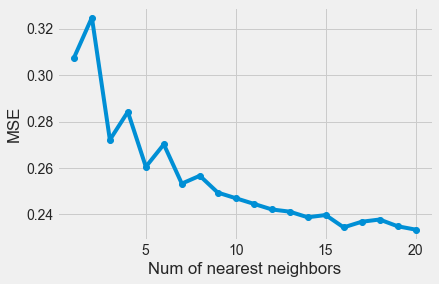

Min MSE is 0.23344610923151282 when K is 20


,Method,Accuracy,Sensiticity,Specificity,PPR,NPR,F-1 scores
0,SVM,0.768487,0.773821,0.763107,0.767176,0.769833,0.770484
1,KNN,0.766554,0.756497,0.776699,0.773622,0.759734,0.764964
2,Random Forest Classification,0.768487,0.766121,0.770874,0.771318,0.765670,0.768711


In [104]:
X = dt_c.drop(['user_rating'], axis=1)
X_scaled = preprocessing.scale(X)
y = dt_c['user_rating']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=13)
classification_result(X_train, X_test, y_train, y_test)

#### (1.b)	use the rating for current version and current rating count to predict the rating of all versions 
#(x contains user_rating_ver, rating_count_ver and delete rating_count_tot.)

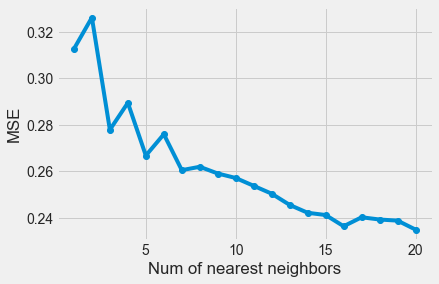

Min MSE is 0.23489608506524892 when K is 20


,Method,Accuracy,Sensiticity,Specificity,PPR,NPR,F-1 scores
0,SVM,0.767037,0.768046,0.766019,0.768046,0.766019,0.768046
1,KNN,0.765104,0.748797,0.781553,0.775673,0.755159,0.761998
2,Random Forest Classification,0.768487,0.766121,0.770874,0.771318,0.765670,0.768711


In [105]:
Xb = dt_c.drop(['user_rating', 'rating_count_tot'], axis=1)
X_scaledb = preprocessing.scale(Xb)
yb = dt_c['user_rating']
X_trainb, X_testb, y_trainb, y_testb = train_test_split(X_scaledb, yb, test_size=0.33, random_state=13)
classification_result(X_trainb, X_testb, y_trainb, y_testb)

### 3.3.3.1 Random Forest Classifier

### Baseline Model

In [106]:
rfc_baseline = RandomForestClassifier(random_state = 13)

In [107]:
report_model_score(rfc_baseline, X_trainb, y_trainb)

Model Report: 
Mean cv score: 0.744 +/- std: 0.006


### Visualize Confusion Matrix

In [108]:
_ = rfc_baseline.fit(X_trainb, y_trainb)

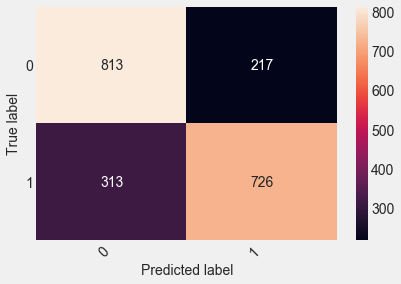

In [109]:
y_pred_rfc = rfc_baseline.predict(X_testb)
plot_confusion_matrix(confusion_matrix(y_testb, y_pred_rfc))

### Test Accuracy

In [110]:
print('The test accuracy for baseline model (rf) is {:.3f}'.
      format(rfc_baseline.score(X_testb, y_testb)))

The test accuracy for baseline model (rf) is 0.744


## Hyper-parameters Tuning

### Step 1: Finding the best initial number of estimators

In [111]:
rfc = RandomForestClassifier(random_state=13)
param_test1_rfc = {"n_estimators": np.arange(20, 101, 20)}

In [112]:
grid_search = GridSearchCV(rfc, param_grid=param_test1_rfc, cv=3, n_jobs=-1)
_ = grid_search.fit(X_trainb, y_trainb)

In [113]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.7638, Standard Deviation: 0.0020
Parameters: {'n_estimators': 40}

Model with rank: 2
Mean validation score: 0.7628, Standard Deviation: 0.0007
Parameters: {'n_estimators': 80}

Model with rank: 3
Mean validation score: 0.7611, Standard Deviation: 0.0014
Parameters: {'n_estimators': 100}



### Step 2: Tuning max_depth, min_samples_split, min_samples_leaf and max_features

In [114]:
rfc = RandomForestClassifier(n_estimators=40, random_state=13)

param_test2_rfc = {
    "max_depth": np.arange(1, 16, 1),
    "min_samples_split": np.arange(200, 1001, 200)
}

In [115]:
grid_search = GridSearchCV(rfc, param_grid=param_test2_rfc, cv=3, n_jobs=-1)
_ = grid_search.fit(X_trainb, y_trainb)

In [116]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.7890, Standard Deviation: 0.0077
Parameters: {'max_depth': 2, 'min_samples_split': 600}

Model with rank: 2
Mean validation score: 0.7890, Standard Deviation: 0.0077
Parameters: {'max_depth': 2, 'min_samples_split': 800}

Model with rank: 3
Mean validation score: 0.7890, Standard Deviation: 0.0074
Parameters: {'max_depth': 3, 'min_samples_split': 600}



In [117]:
rfc = RandomForestClassifier(n_estimators=40, max_depth=2, min_samples_split=600, random_state=13)

param_test3_rfc = {
    "min_samples_leaf": np.arange(1, 11, 1),
}

In [118]:
grid_search = GridSearchCV(rfc, param_grid=param_test3_rfc, cv=3, n_jobs=-1)
_ = grid_search.fit(X_trainb, y_trainb)

In [119]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.7890, Standard Deviation: 0.0077
Parameters: {'min_samples_leaf': 1}

Model with rank: 2
Mean validation score: 0.7890, Standard Deviation: 0.0077
Parameters: {'min_samples_leaf': 2}

Model with rank: 3
Mean validation score: 0.7890, Standard Deviation: 0.0077
Parameters: {'min_samples_leaf': 3}



In [120]:
rfc = RandomForestClassifier(n_estimators=40, min_samples_split=600, min_samples_leaf=1,
                               max_depth=2, random_state=13)

param_test4_rfc = {
    "max_features": np.arange(1, 9, 1)
}

In [121]:
grid_search = GridSearchCV(rfc, param_grid=param_test4_rfc, cv=3, n_jobs=-1)
_ = grid_search.fit(X_trainb, y_trainb)

In [122]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.7890, Standard Deviation: 0.0077
Parameters: {'max_features': 3}

Model with rank: 2
Mean validation score: 0.7885, Standard Deviation: 0.0080
Parameters: {'max_features': 5}

Model with rank: 3
Mean validation score: 0.7883, Standard Deviation: 0.0083
Parameters: {'max_features': 2}



In [123]:
rfc = RandomForestClassifier(n_estimators=40, min_samples_split=600, min_samples_leaf=1,
                               max_depth=2, max_features=3, random_state=13)

param_test5_rfc = {
    "n_estimators": np.arange(80, 200, 20)
}

In [124]:
grid_search = GridSearchCV(rfc, param_grid=param_test5_rfc, cv=3, n_jobs=-1)
_ = grid_search.fit(X_trainb, y_trainb)

In [125]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.7883, Standard Deviation: 0.0080
Parameters: {'n_estimators': 80}

Model with rank: 2
Mean validation score: 0.7883, Standard Deviation: 0.0080
Parameters: {'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.7883, Standard Deviation: 0.0080
Parameters: {'n_estimators': 120}



## Final Random Forest Classifier

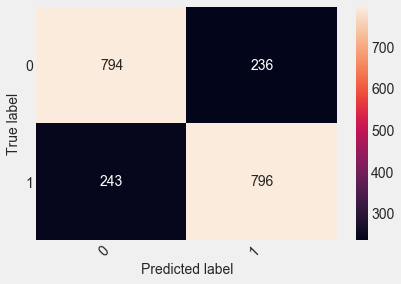

In [126]:
rfc_final = RandomForestClassifier(n_estimators=40, min_samples_split=600, min_samples_leaf=1,
                               max_depth=2, max_features=3, random_state=13)

rfc_final.fit(X_trainb, y_trainb)

y_pred_rfc = rfc_final.predict(X_testb)
plot_confusion_matrix(confusion_matrix(y_testb, y_pred_rfc))

In [127]:
print('The test accuracy for final model (rf) is {:.4f}'.
      format(rfc_final.score(X_testb, y_testb)))

The test accuracy for final model (rf) is 0.7685


### 3.3.4 Test 2 - Predicting User Rating for current version

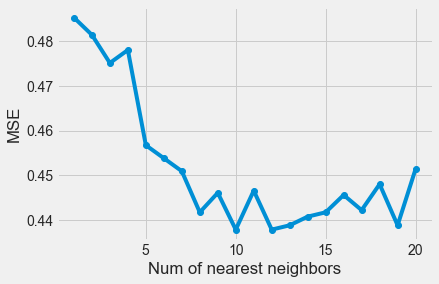

Min MSE is 0.43789270178830353 when K is 12


,Method,Accuracy,Sensiticity,Specificity,PPR,NPR,F-1 scores
0,SVM,0.567907,0.729651,0.406943,0.550439,0.601997,0.627500
1,KNN,0.548574,0.511628,0.585342,0.551148,0.546355,0.530653
2,Random Forest Classification,0.575157,0.721899,0.429122,0.557218,0.607923,0.628957


In [128]:
#(2)	delete rating_count_tot, user_rating_ver, rating_count_ver and rating_count_tot
X_d = dt_c.drop(['user_rating','user_rating_ver', 'rating_count_ver','rating_count_tot'], axis=1)
X_scaled_d = preprocessing.scale(X_d)
y_d = dt_c['user_rating_ver']
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_scaled_d, y_d, test_size=0.33, random_state=13)
classification_result(X_train_d, X_test_d, y_train_d, y_test_d)

## Text Mining Results

In [145]:
df_game = df_game[df_game['user_rating'] != 0]
cols_drop_g = ['id','track_name','currency','ver', 'prime_genre', 'app_desc']
dt_game = df_game.drop(cols_drop_g, axis = 1)
display(dt_game.head())
dt_game_org = dt_game.drop('highFre_Check', axis =1)
display(dt_game_org.head())
#display((df_game[df_game['highFre_Check'] == 0]).head(20))

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,cont_rating,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,highFre_Check
0,100788224,3.99,21292,26,4.0,4.5,1,38,5,10,1,1
5,10485713,0.99,8253,5516,4.0,4.0,1,47,5,1,1,1
9,70023168,3.99,7885,40,4.0,4.0,1,38,0,10,1,1
10,49618944,4.99,76720,4017,4.5,4.5,1,38,4,11,1,1
11,227547136,7.99,105776,166,3.5,2.5,1,37,0,6,1,1


,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,cont_rating,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,100788224,3.99,21292,26,4.0,4.5,1,38,5,10,1
5,10485713,0.99,8253,5516,4.0,4.0,1,47,5,1,1
9,70023168,3.99,7885,40,4.0,4.0,1,38,0,10,1
10,49618944,4.99,76720,4017,4.5,4.5,1,38,4,11,1
11,227547136,7.99,105776,166,3.5,2.5,1,37,0,6,1


Test2

In [149]:
#org(2)	delete rating_count_tot, user_rating_ver and rating_count_ver
Xg_do = dt_game_org.drop(['user_rating_ver', 'user_rating', 'rating_count_ver', 'rating_count_tot'], axis=1)
X_scaledg_do = preprocessing.scale(Xg_d)
yg_do = dt_game_org['user_rating_ver']
X_traing_do, X_testg_do, y_traing_do, y_testg_do = train_test_split(X_scaledg_do, yg_do, test_size=0.33, random_state=13)
regression_result(X_traing_do, X_testg_do, y_traing_do, y_testg_do)

,Method,MSE,R,AdjustedR
0,Linear Rgression,1.107116,0.000156,-0.006126
1,Random_Forest_Regression,1.448830,-0.308448,-0.316669
2,SVR,1.179136,-0.064885,-0.071576


In [150]:
#(2)	delete rating_count_tot, user_rating_ver and rating_count_ver
Xg_d = dt_game.drop(['user_rating_ver', 'user_rating', 'rating_count_ver', 'rating_count_tot'], axis=1)
X_scaledg_d = preprocessing.scale(Xg_d)
yg_d = dt_game['user_rating_ver']
X_traing_d, X_testg_d, y_traing_d, y_testg_d = train_test_split(X_scaledg_d, yg_d, test_size=0.33, random_state=13)
regression_result(X_traing_d, X_testg_d, y_traing_d, y_testg_d)

,Method,MSE,R,AdjustedR
0,Linear Rgression,1.107813,-0.000473,-0.007664
1,Random_Forest_Regression,1.391842,-0.256981,-0.266016
2,SVR,1.178581,-0.064384,-0.072034


In [151]:
dt_gc = dt_game.copy()
dt_gc["user_rating"] = dt_gc["user_rating"].replace([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0], 0)
dt_gc["user_rating"] = dt_gc["user_rating"].replace([4.5, 5.0], 1)

dt_gc["user_rating_ver"] = dt_gc["user_rating_ver"].replace([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0], 0)
dt_gc["user_rating_ver"] = dt_gc["user_rating_ver"].replace([4.5, 5.0], 1)

In [152]:
display(dt_gc.head())
dt_gc_org = dt_gc.drop('highFre_Check', axis =1)
display(dt_gc_org.head())

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,cont_rating,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,highFre_Check
0,100788224,3.99,21292,26,0.0,1.0,1,38,5,10,1,1
5,10485713,0.99,8253,5516,0.0,0.0,1,47,5,1,1,1
9,70023168,3.99,7885,40,0.0,0.0,1,38,0,10,1,1
10,49618944,4.99,76720,4017,1.0,1.0,1,38,4,11,1,1
11,227547136,7.99,105776,166,0.0,0.0,1,37,0,6,1,1


,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,cont_rating,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,100788224,3.99,21292,26,0.0,1.0,1,38,5,10,1
5,10485713,0.99,8253,5516,0.0,0.0,1,47,5,1,1
9,70023168,3.99,7885,40,0.0,0.0,1,38,0,10,1
10,49618944,4.99,76720,4017,1.0,1.0,1,38,4,11,1
11,227547136,7.99,105776,166,0.0,0.0,1,37,0,6,1


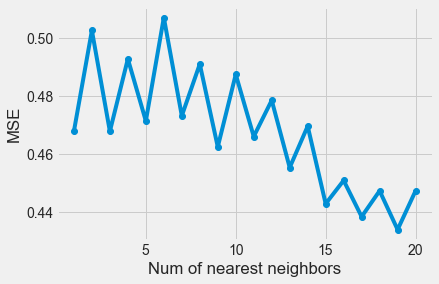

Min MSE is 0.43404634581105167 when K is 19


,Method,Accuracy,Sensiticity,Specificity,PPR,NPR,F-1 scores
0,SVM,0.574866,0.831008,0.228512,0.592920,0.500000,0.692059
1,KNN,0.552585,0.654264,0.415094,0.601997,0.470309,0.627043
2,Random Forest Classification,0.573084,0.896124,0.136268,0.583838,0.492424,0.707034


In [153]:
#org(2)	delete rating_count_tot, user_rating_ver, rating_count_ver and rating_count_tot
X_gdo = dt_gc.drop(['user_rating','user_rating_ver', 'rating_count_ver','rating_count_tot'], axis=1)
X_scaled_gdo = preprocessing.scale(X_gd)
y_gdo = dt_gc['user_rating_ver']
X_train_gdo, X_test_gdo, y_train_gdo, y_test_gdo = train_test_split(X_scaled_gdo, y_gdo, test_size=0.33, random_state=13)
classification_result(X_train_gdo, X_test_gdo, y_train_gdo, y_test_gdo)

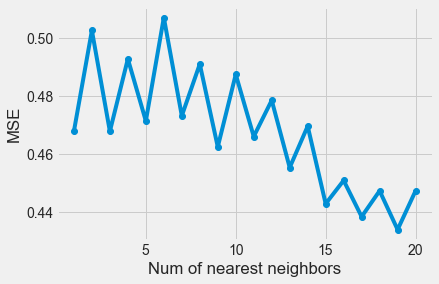

Min MSE is 0.43404634581105167 when K is 19


,Method,Accuracy,Sensiticity,Specificity,PPR,NPR,F-1 scores
0,SVM,0.574866,0.831008,0.228512,0.592920,0.500000,0.692059
1,KNN,0.552585,0.654264,0.415094,0.601997,0.470309,0.627043
2,Random Forest Classification,0.573084,0.896124,0.136268,0.583838,0.492424,0.707034


In [154]:
#(2)	delete rating_count_tot, user_rating_ver, rating_count_ver and rating_count_tot
X_gd = dt_gc.drop(['user_rating','user_rating_ver', 'rating_count_ver','rating_count_tot'], axis=1)
X_scaled_gd = preprocessing.scale(X_gd)
y_gd = dt_gc['user_rating_ver']
X_train_gd, X_test_gd, y_train_gd, y_test_gd = train_test_split(X_scaled_gd, y_gd, test_size=0.33, random_state=13)
classification_result(X_train_gd, X_test_gd, y_train_gd, y_test_gd)